In [1]:
using PairwiseListMatrices
using BenchmarkTools
using Base.Test
using Gadfly

In [2]:
# Similar to pairwise of Distances.jl
function using_full(vecs)
  n = length(vecs)
  mat = Array(Float64, n, n)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      mat[i,j] = cor(vec_i, vecs[j])
    end
    for j = 1 : (i-1)
      @inbounds mat[i,j] = mat[j,i]  # leveraging the symmetry
    end
  end
  mat
end

function using_symmetric(vecs)
  n = length(vecs)
  mat = Array(Float64, n, n)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      mat[i,j] = cor(vec_i, vecs[j])
    end
  end
  Symmetric(mat)
end

function using_sparse_symmetric(vecs)
  n = length(vecs)
  mat = spzeros(Float64, n, n)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      mat[i,j] = cor(vec_i, vecs[j])
    end
  end
  Symmetric(mat)
end

# Creates a list and returns it as a PairwiseListMatrix
function using_pairwiselist(vecs)
  n = length(vecs)
  list = Array(Float64, div(n*(n+1),2))
  k = 1
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      list[k] = cor(vec_i, vecs[j])
      k += 1
    end
  end
  PairwiseListMatrix(list, true)
end

# Creates and fill a PairwiseListMatrix
function using_pairwiselistmatrix(vecs)
  n = length(vecs)
  list = PairwiseListMatrix(Float64, n, true)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      list[i,j] = cor(vec_i, vecs[j])
    end
  end
  list
end

using_pairwiselistmatrix (generic function with 1 method)

In [3]:
const testset = [ rand(3) for n in 1:500 ];

# Test for the same result
@test all(using_sparse_symmetric(testset) .== using_full(testset))
@test all(using_full(testset) .== using_symmetric(testset))
@test all(using_symmetric(testset) .== using_pairwiselist(testset))
@test all(using_pairwiselist(testset) .== using_pairwiselistmatrix(testset))

@benchmark using_symmetric(testset)

BenchmarkTools.Trial: 
  memory estimate:  13.37 mb
  allocs estimate:  751503
  --------------
  minimum time:     26.683 ms (0.00% GC)
  median time:      27.814 ms (3.45% GC)
  mean time:        28.002 ms (2.15% GC)
  maximum time:     31.837 ms (3.41% GC)
  --------------
  samples:          179
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [4]:
@benchmark using_full(testset)

BenchmarkTools.Trial: 
  memory estimate:  13.37 mb
  allocs estimate:  751502
  --------------
  minimum time:     27.017 ms (0.00% GC)
  median time:      28.999 ms (3.53% GC)
  mean time:        29.155 ms (2.26% GC)
  maximum time:     33.073 ms (3.39% GC)
  --------------
  samples:          172
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [5]:
@benchmark using_pairwiselist(testset)

BenchmarkTools.Trial: 
  memory estimate:  12.42 mb
  allocs estimate:  751504
  --------------
  minimum time:     26.359 ms (0.00% GC)
  median time:      28.003 ms (3.81% GC)
  mean time:        28.180 ms (2.24% GC)
  maximum time:     31.582 ms (3.73% GC)
  --------------
  samples:          178
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [6]:
@benchmark using_pairwiselistmatrix(testset)

BenchmarkTools.Trial: 
  memory estimate:  10.51 mb
  allocs estimate:  626254
  --------------
  minimum time:     23.046 ms (0.00% GC)
  median time:      24.127 ms (0.00% GC)
  mean time:        24.055 ms (2.16% GC)
  maximum time:     31.092 ms (3.47% GC)
  --------------
  samples:          208
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [7]:
const SAMPLES = collect(10:100:1000)
const TIME = zeros(Float64, length(SAMPLES)*5)
const NAMES = vcat([ ["full", "symmetric", "sparse", "list", "pairwiselistmatrix"] for i in 1:length(SAMPLES) ]...)
const XS = vcat([ [x, x, x, x, x] for x in SAMPLES ]...)

k = 0
for sample in SAMPLES
    test = [ rand(3) for n in 1:sample ]
    k += 1
    TIME[k] = @elapsed using_full(test)
    k += 1
    TIME[k] = @elapsed using_symmetric(test)
    k += 1
    TIME[k] = sample <= 410 ? @elapsed( using_sparse_symmetric(test) ) : NaN
    k += 1
    TIME[k] = @elapsed using_pairwiselist(test)
    k += 1
    TIME[k] = @elapsed using_pairwiselistmatrix(test)
end

In [8]:
plot(x=XS, y=TIME, color=NAMES, Geom.point, Scale.y_sqrt)

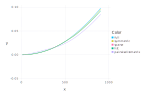

In [9]:
plot(x=XS, y=TIME, color=NAMES, Geom.smooth)